# Проект: Предсказание отмен клиентских сессий

## Зависимости

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, classification_report, mutual_info_score, accuracy_score
from sklearn.tree import export_text
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

import pickle

sns.set_style("whitegrid")
sns.set_palette('muted')

In [99]:
for package in [pd, np, mpl, sns, sklearn, xgb, pickle, lgb]:
    if package == pickle: print(f'{package.__name__:<12}: {package.format_version}')
    else: print(f'{package.__name__:<12}: {package.__version__}')

pandas      : 2.2.3
numpy       : 1.26.4
matplotlib  : 3.10.0
seaborn     : 0.13.2
sklearn     : 1.6.1
xgboost     : 3.0.1
pickle      : 4.0
lightgbm    : 4.6.0


# Загрузка данных

Данные о бронированиях клиентских сессий содержат информацию о планируемых встречах и фактах их отмены.

Описание столбцов и типов данных можно найти в документации проекта.

In [100]:
data_source = 'C:/Users/archibrat/Desktop/обучение/ml_eng/MFDP-main/MFDP-main/data/KaggleV2-May-2016.csv'
#data_source = '/kaggle/input/noshowappointments/KaggleV2-May-2016.csv'

In [101]:
dataset = pd.read_csv(data_source, 
                 parse_dates=['ScheduledDay', 'AppointmentDay'],
                 dtype={
                            'Scholarship':'bool',
                            'Hipertension':'bool',
                            'Diabetes':'bool',
                            'Alcoholism':'bool',
                            'SMS_received':'bool'
                     }
              )
dataset.info()
dataset.tail().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  bool               
 8   Hipertension    110527 non-null  bool               
 9   Diabetes        110527 non-null  bool               
 10  Alcoholism      110527 non-null  bool               
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  bool               
 13  No-show       

,110522,110523,110524,110525,110526
PatientId,2572134369293.0,3596266328735.0,15576631729893.0,92134931435557.0,377511518121127.0
AppointmentID,5651768,5650093,5630692,5630323,5629448
Gender,F,F,F,F,F
ScheduledDay,2016-05-03 09:15:35+00:00,2016-05-03 07:27:33+00:00,2016-04-27 16:03:52+00:00,2016-04-27 15:09:23+00:00,2016-04-27 13:30:56+00:00
AppointmentDay,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00,2016-06-07 00:00:00+00:00
Age,56,51,21,38,54
Neighbourhood,MARIA ORTIZ,MARIA ORTIZ,MARIA ORTIZ,MARIA ORTIZ,MARIA ORTIZ
Scholarship,False,False,False,False,False
Hipertension,False,False,False,False,False
Diabetes,False,False,False,False,False


In [102]:
dataset.rename(columns={'Hipertension':'Hypertension'}, inplace=True)

# Очистка и подготовка данных

* Исправление опечаток в названиях
* Приведение колонок к нижнему регистру
* Унификация строковых значений категориальных переменных
* Обработка пропущенных значений [в данном наборе их нет]
* Преобразование целевой переменной в булевый тип

In [103]:
# Переименование колонок для унификации
column_mapping = {
    'PatientId': 'client_id',
    'AppointmentID': 'booking_id', 
    'Gender': 'gender',
    'ScheduledDay': 'planned_date',
    'AppointmentDay': 'session_date',
    'Age': 'age',
    'Neighbourhood': 'district',
    'Scholarship': 'subsidy',
    'Hypertension': 'condition_a',
    'Diabetes': 'condition_b', 
    'Alcoholism': 'condition_c',
    'Handcap': 'accessibility_level',
    'SMS_received': 'notification_sent',
    'No-show': 'session_cancel'
}

dataset = dataset.rename(columns=column_mapping)

In [104]:
# Приведение к нижнему регистру
dataset.columns = [col.lower() for col in dataset.columns]

# Преобразование категориальных значений
dataset['gender'] = dataset['gender'].str.lower()
dataset['district'] = dataset['district'].str.lower().str.replace(' ', '_')

# Преобразование целевой переменной
dataset['session_cancel'] = (dataset['session_cancel'] == 'Yes').astype(int)

# Исследовательский анализ данных

* Анализ целевой переменной
* Изучение входных признаков:
    * ID клиентов и бронирований
    * Временные переменные: даты планирования и проведения
    * Категориальные/дискретные переменные
    * Непрерывные переменные

## Целевая переменная: Отмена сессии

In [105]:
# Анализ распределения целевой переменной
cancel_rate = dataset['session_cancel'].value_counts()
print(f"Распределение отмен сессий:\n{cancel_rate}")
print(f"Доля отмен: {dataset['session_cancel'].mean():.3f}")

Распределение отмен сессий:
session_cancel
0    88208
1    22319
Name: count, dtype: int64
Доля отмен: 0.202


## Входные признаки

### ID клиентов и бронирований
* Набор данных содержит 1.77 бронирований на уникального клиента
* Удаляем колонку booking_id так как она не несет информационной ценности

In [106]:
# Анализ уникальности идентификаторов
print(f"Уникальных клиентов: {dataset['client_id'].nunique()}")
print(f"Общее количество бронирований: {len(dataset)}")
print(f"Среднее количество бронирований на клиента: {len(dataset) / dataset['client_id'].nunique():.2f}")

# Удаление избыточной колонки
dataset = dataset.drop('booking_id', axis=1)

Уникальных клиентов: 62299
Общее количество бронирований: 110527
Среднее количество бронирований на клиента: 1.77


### Временные колонки: ['planned_date', 'session_date']

* Какие временные периоды охватывают данные?
* Как выглядят временные ряды?

Период планирования: 2015-11-10 07:13:56+00:00 - 2016-06-08 20:07:23+00:00
Период проведения сессий: 2016-04-29 00:00:00+00:00 - 2016-06-08 00:00:00+00:00


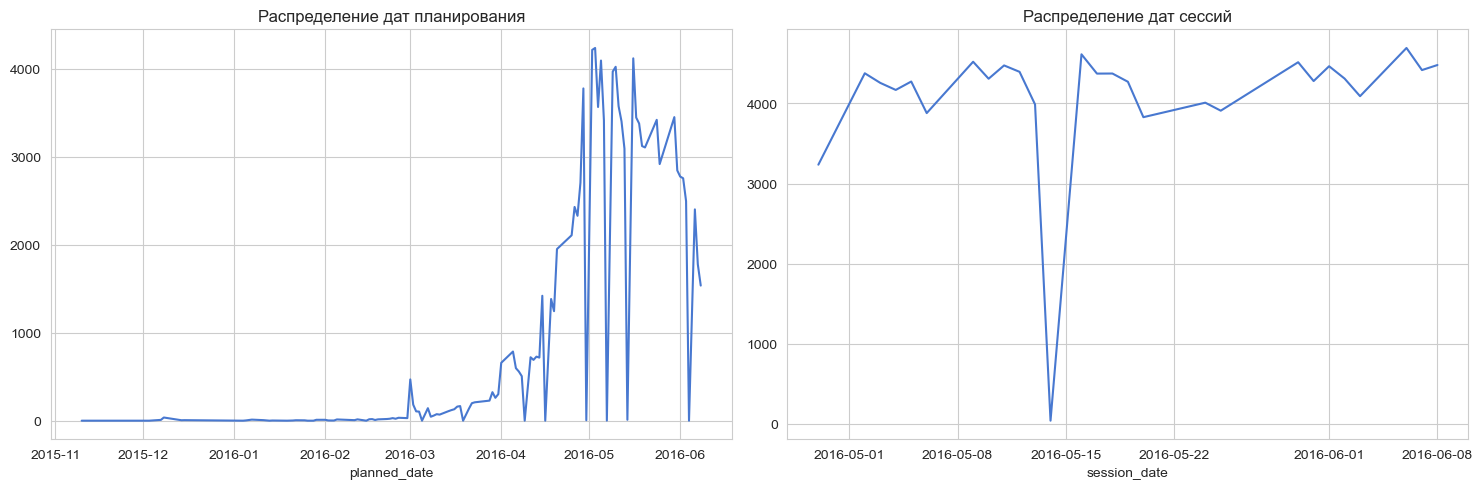

In [107]:
# Анализ временных периодов
print(f"Период планирования: {dataset['planned_date'].min()} - {dataset['planned_date'].max()}")
print(f"Период проведения сессий: {dataset['session_date'].min()} - {dataset['session_date'].max()}")

# Визуализация временных рядов
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

dataset['planned_date'].dt.date.value_counts().sort_index().plot(ax=axes[0], title='Распределение дат планирования')
dataset['session_date'].dt.date.value_counts().sort_index().plot(ax=axes[1], title='Распределение дат сессий')

plt.tight_layout()
plt.show()

### Дискретные переменные

* 'gender', 
* 'district'
* 'subsidy'
* 'condition_a',
* 'condition_b'
* 'condition_c'
* 'accessibility_level'
* 'notification_sent'

In [108]:
# Анализ категориальных переменных
categorical_features = ['gender', 'district', 'subsidy', 'condition_a', 'condition_b', 'condition_c', 'accessibility_level', 'notification_sent']

for feature in categorical_features:
    print(f"\n{feature}:")
    print(dataset[feature].value_counts())
    print(f"Уникальных значений: {dataset[feature].nunique()}")


gender:
gender
f    71840
m    38687
Name: count, dtype: int64
Уникальных значений: 2

district:
district
jardim_camburi                 7717
maria_ortiz                    5805
resistência                    4431
jardim_da_penha                3877
itararé                        3514
                               ... 
ilha_do_boi                      35
ilha_do_frade                    10
aeroporto                         8
ilhas_oceânicas_de_trindade       2
parque_industrial                 1
Name: count, Length: 81, dtype: int64
Уникальных значений: 81

subsidy:
subsidy
False    99666
True     10861
Name: count, dtype: int64
Уникальных значений: 2

condition_a:
condition_a
False    88726
True     21801
Name: count, dtype: int64
Уникальных значений: 2

condition_b:
condition_b
False    102584
True       7943
Name: count, dtype: int64
Уникальных значений: 2

condition_c:
condition_c
False    107167
True       3360
Name: count, dtype: int64
Уникальных значений: 2

accessibility_leve

### Непрерывные переменные: Возраст

Статистика по возрасту:
count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64


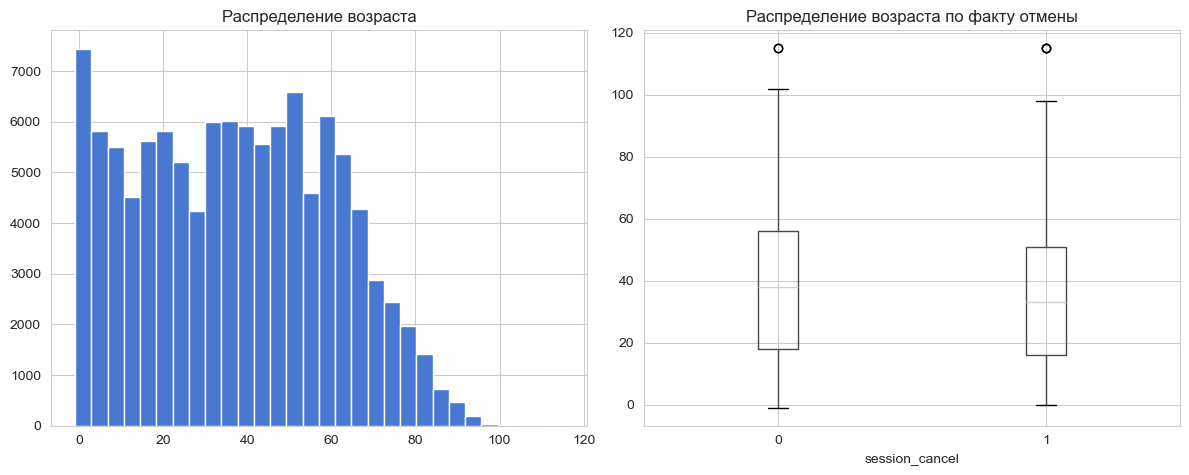

In [109]:
# Анализ возрастного распределения
print(f"Статистика по возрасту:")
print(dataset['age'].describe())

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма распределения возраста
dataset['age'].hist(bins=30, ax=axes[0])
axes[0].set_title('Распределение возраста')  # Установка заголовка для первого графика

# Боксплот с группировкой по целевому признаку
dataset.boxplot(column='age', by='session_cancel', ax=axes[1])
axes[1].set_title('Распределение возраста по факту отмены')  # Заголовок для второго графика

plt.suptitle('')  # Сброс общего заголовка, генерируемого pandas
plt.tight_layout()
plt.show()


# Конструирование признаков

* Создание признаков на основе временных данных из 'planned_date' и 'session_date' для обработки как числовые или категориальные данные
* Удаление исходных временных колонок
* Удаление колонок с единственным уникальным значением

In [110]:
def create_temporal_features(data_frame, date_col, prefix):
    """Создание временных признаков из даты"""
    features = {}
    features[f'{prefix}Year'] = data_frame[date_col].dt.year
    features[f'{prefix}Month'] = data_frame[date_col].dt.month
    features[f'{prefix}Week'] = data_frame[date_col].dt.isocalendar().week
    features[f'{prefix}Day'] = data_frame[date_col].dt.day
    features[f'{prefix}Dayofweek'] = data_frame[date_col].dt.dayofweek
    features[f'{prefix}Dayofyear'] = data_frame[date_col].dt.dayofyear
    features[f'{prefix}Is_month_end'] = data_frame[date_col].dt.is_month_end
    features[f'{prefix}Is_month_start'] = data_frame[date_col].dt.is_month_start
    features[f'{prefix}Is_quarter_end'] = data_frame[date_col].dt.is_quarter_end
    features[f'{prefix}Is_quarter_start'] = data_frame[date_col].dt.is_quarter_start
    features[f'{prefix}Hour'] = data_frame[date_col].dt.hour
    features[f'{prefix}Minute'] = data_frame[date_col].dt.minute
    features[f'{prefix}Second'] = data_frame[date_col].dt.second
    
    return pd.DataFrame(features)

# Применение функции к временным колонкам
planned_features = create_temporal_features(dataset, 'planned_date', 'plannedday')
session_features = create_temporal_features(dataset, 'session_date', 'sessionday')

# Объединение с основным датасетом
dataset = pd.concat([dataset, planned_features, session_features], axis=1)

# Удаление исходных временных колонок
dataset = dataset.drop(['planned_date', 'session_date'], axis=1)

# Разделение на категориальные и числовые признаки

* Разделение датасета на числовые и категориальные признаки в зависимости от количества уникальных значений (< или > 10)
* Исключение целевой переменной из списка категориальных колонок
* Особая обработка для 'district' которая имеет 81 уникальное значение но является категориальной

In [111]:
# Определение типов признаков
numerical_features = []
categorical_features = []

for column in dataset.columns:
    if column == 'session_cancel':  # Исключаем целевую переменную
        continue
    elif column == 'district':  # Особая обработка района
        categorical_features.append(column)
    elif dataset[column].nunique() > 10:
        numerical_features.append(column)
    else:
        categorical_features.append(column)

print(f"Числовые признаки ({len(numerical_features)}): {numerical_features}")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

Числовые признаки (10): ['client_id', 'age', 'planneddayWeek', 'planneddayDay', 'planneddayDayofyear', 'planneddayHour', 'planneddayMinute', 'planneddaySecond', 'sessiondayDay', 'sessiondayDayofyear']
Категориальные признаки (26): ['gender', 'district', 'subsidy', 'condition_a', 'condition_b', 'condition_c', 'accessibility_level', 'notification_sent', 'planneddayYear', 'planneddayMonth', 'planneddayDayofweek', 'planneddayIs_month_end', 'planneddayIs_month_start', 'planneddayIs_quarter_end', 'planneddayIs_quarter_start', 'sessiondayYear', 'sessiondayMonth', 'sessiondayWeek', 'sessiondayDayofweek', 'sessiondayIs_month_end', 'sessiondayIs_month_start', 'sessiondayIs_quarter_end', 'sessiondayIs_quarter_start', 'sessiondayHour', 'sessiondayMinute', 'sessiondaySecond']


# Важность признаков

## Важность признаков: Взаимная информация

Взаимная информация: концепция из теории информации, показывает сколько информации об одной переменной мы можем получить, зная значение другой

In [112]:
# Расчет взаимной информации для категориальных признаков
mutual_info_cancel_score = {}

for feature in categorical_features:
    score = mutual_info_score(dataset[feature], dataset['session_cancel'])
    mutual_info_cancel_score[feature] = score

# Сортировка по важности
sorted_mi_scores = sorted(mutual_info_cancel_score.items(), key=lambda x: x[1], reverse=True)

print("Взаимная информация с целевой переменной:")
for feature, score in sorted_mi_scores:
    print(f"{feature}: {score:.4f}")

Взаимная информация с целевой переменной:
planneddayMonth: 0.0151
notification_sent: 0.0077
district: 0.0022
condition_a: 0.0007
sessiondayWeek: 0.0005
subsidy: 0.0004
sessiondayMonth: 0.0003
planneddayIs_quarter_end: 0.0002
planneddayIs_month_end: 0.0001
sessiondayDayofweek: 0.0001
planneddayIs_quarter_start: 0.0001
condition_b: 0.0001
planneddayIs_month_start: 0.0001
sessiondayIs_month_end: 0.0001
sessiondayIs_month_start: 0.0001
planneddayDayofweek: 0.0000
accessibility_level: 0.0000
planneddayYear: 0.0000
gender: 0.0000
condition_c: 0.0000
sessiondayYear: 0.0000
sessiondayIs_quarter_end: 0.0000
sessiondayIs_quarter_start: 0.0000
sessiondayHour: 0.0000
sessiondayMinute: 0.0000
sessiondaySecond: 0.0000


## Важность признаков: Корреляция

Для числовых колонок используем коэффициент корреляции Пирсона

Корреляция числовых признаков с целевой переменной:
planneddayDayofyear: 0.1573
planneddayWeek: 0.1564
planneddayHour: 0.0607
age: 0.0603
planneddayDay: 0.0466
sessiondayDayofyear: 0.0224
planneddayMinute: 0.0150
sessiondayDay: 0.0038
planneddaySecond: 0.0018
client_id: 0.0015


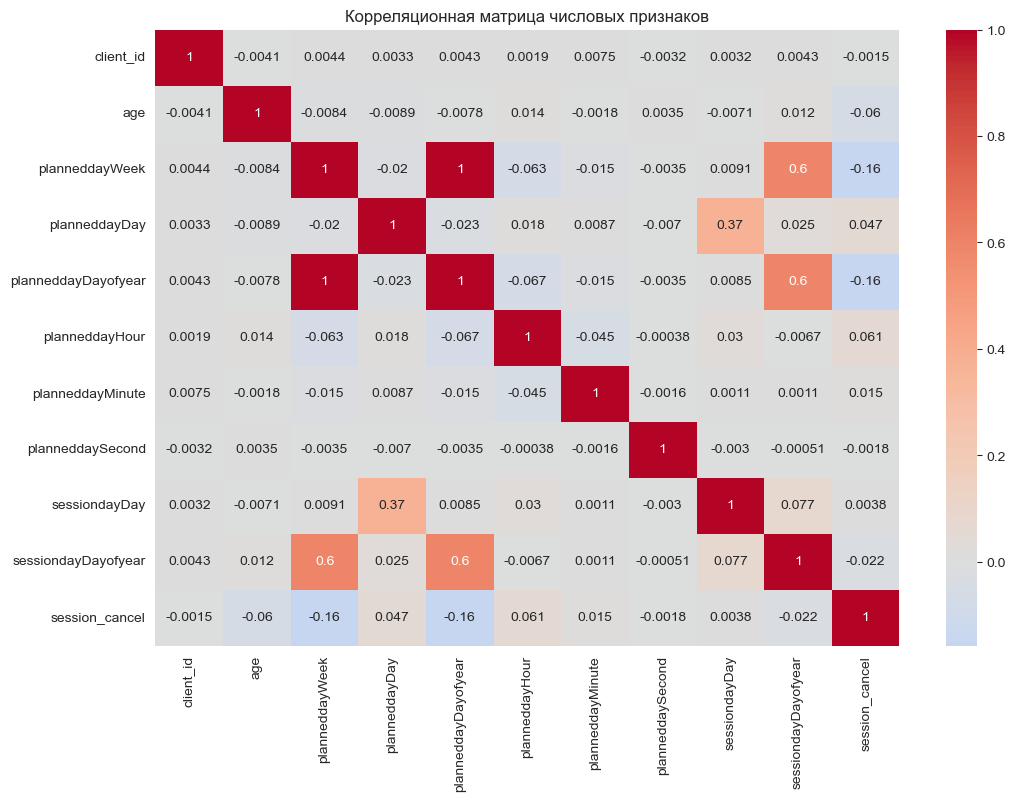

In [113]:
# Корреляция числовых признаков с целевой переменной
corr_with_target = dataset[numerical_features + ['session_cancel']].corr()['session_cancel'].abs().sort_values(ascending=False)

print("Корреляция числовых признаков с целевой переменной:")
for feature, corr in corr_with_target.items():
    if feature != 'session_cancel':
        print(f"{feature}: {corr:.4f}")

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(dataset[numerical_features + ['session_cancel']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

# Настройка фреймворка валидации

* Выполнение разделения на train/validation/test с помощью Scikit-Learn

In [114]:
# Подготовка данных для моделирования
features = numerical_features + categorical_features
X = dataset[features]
y = dataset['session_cancel']

# Разделение на train/val/test
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=42, stratify=y_full_train)

print(f"Размеры выборок:")
print(f"Обучающая: {X_train.shape[0]}")
print(f"Валидационная: {X_val.shape[0]}")
print(f"Тестовая: {X_test.shape[0]}")

print(f"\nРаспределение целевой переменной:")
print(f"Обучающая: {y_train.mean():.3f}")
print(f"Валидационная: {y_val.mean():.3f}")
print(f"Тестовая: {y_test.mean():.3f}")

Размеры выборок:
Обучающая: 66315
Валидационная: 22106
Тестовая: 22106

Распределение целевой переменной:
Обучающая: 0.202
Валидационная: 0.202
Тестовая: 0.202


# Подготовка данных-II: Масштабирование признаков + OHE

### Обучающая выборка: Масштабирование признаков

Сначала подготавливаем числовые переменные. Используем скейлер и записываем результаты в `X_train_num`. Скейлер масштабирует числовые признаки.

In [115]:
# Обработка числовых признаков
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_train_num = pd.DataFrame(X_train_num, columns=numerical_features, index=X_train.index)

print(f"Обработанные числовые признаки: {X_train_num.shape}")
print(X_train_num.head())

Обработанные числовые признаки: (66315, 10)
       client_id       age  planneddayWeek  planneddayDay  \
83641  -0.574433  0.948438        0.093533      -0.562251   
88135  -0.405647 -1.563544        0.093533      -0.241441   
22117  -0.466802 -0.913894       -0.623081       1.362606   
75813  -0.574924 -0.783963        0.093533      -0.562251   
46234  -0.239306  1.901258        0.093533      -0.241441   

       planneddayDayofyear  planneddayHour  planneddayMinute  \
83641            -0.001115        1.311275          0.816156   
88135             0.153635        1.622174         -1.447904   
22117            -0.620117       -0.865018         -0.228795   
75813            -0.001115        1.311275          1.512790   
46234             0.153635       -0.865018          0.816156   

       planneddaySecond  sessiondayDay  sessiondayDayofyear  
83641         -1.132356      -0.388053            -0.822459  
88135          0.431123      -0.498249             1.641003  
22117          0.8

Теперь обработаем категориальные признаки с помощью OneHotEncoding. Записываем результаты в `X_train_cat`.

In [116]:
# Обработка категориальных признаков
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train[categorical_features])
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(categorical_features), index=X_train.index)

print(f"Обработанные категориальные признаки: {X_train_cat.shape}")
print(X_train_cat.head())

# Объединение всех признаков
X_train_processed = pd.concat([X_train_num, X_train_cat], axis=1)
print(f"Итоговая обучающая выборка: {X_train_processed.shape}")

Обработанные категориальные признаки: (66315, 147)
       gender_f  gender_m  district_aeroporto  district_andorinhas  \
83641       1.0       0.0                 0.0                  0.0   
88135       0.0       1.0                 0.0                  0.0   
22117       1.0       0.0                 0.0                  0.0   
75813       0.0       1.0                 0.0                  0.0   
46234       1.0       0.0                 0.0                  0.0   

       district_antônio_honório  district_ariovaldo_favalessa  \
83641                       0.0                           0.0   
88135                       0.0                           0.0   
22117                       0.0                           0.0   
75813                       0.0                           0.0   
46234                       0.0                           0.0   

       district_barro_vermelho  district_bela_vista  district_bento_ferreira  \
83641                      0.0                  0.0      

### Валидационная выборка: Преобразование

In [117]:
# Преобразование валидационной выборки
X_val_num = scaler.transform(X_val[numerical_features])
X_val_num = pd.DataFrame(X_val_num, columns=numerical_features, index=X_val.index)

X_val_cat = ohe.transform(X_val[categorical_features])
X_val_cat = pd.DataFrame(X_val_cat, columns=ohe.get_feature_names_out(categorical_features), index=X_val.index)

X_val_processed = pd.concat([X_val_num, X_val_cat], axis=1)
print(f"Валидационная выборка: {X_val_processed.shape}")

Валидационная выборка: (22106, 157)


# Моделирование

## Метрика оценки: ROC AUC

## Базовые модели

Используем две модели для установления базовых показателей:
* Базовая-I: случайное предсказание 'session_cancel' = 0 или 1
* Базовая-II: предсказание всех 'session_cancel' как 1

In [118]:
# Базовые модели
np.random.seed(42)
y_pred_random = np.random.randint(0, 2, size=len(y_val))
y_pred_allone = np.ones(len(y_val))

auc_random = roc_auc_score(y_val, y_pred_random)
auc_allone = roc_auc_score(y_val, y_pred_allone)

print(f"Базовая модель (случайная): AUC = {auc_random:.3f}")
print(f"Базовая модель (все единицы): AUC = {auc_allone:.3f}")

Базовая модель (случайная): AUC = 0.505
Базовая модель (все единицы): AUC = 0.500


## Логистическая регрессия

### Базовая модель

In [119]:
# Логистическая регрессия - базовая модель
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_processed, y_train)

y_pred_lr = lr.predict_proba(X_val_processed)[:, 1]
auc_lr = roc_auc_score(y_val, y_pred_lr)

print(f"Логистическая регрессия (базовая): AUC = {auc_lr:.3f}")

Логистическая регрессия (базовая): AUC = 0.673


### Настройка гиперпараметров: Параметр регуляризации, C

In [120]:
# Подбор гиперпараметров для логистической регрессии
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
lr_scores = []

for C in C_values:
    lr_temp = LogisticRegression(C=C, random_state=42, max_iter=1000)
    lr_temp.fit(X_train_processed, y_train)
    y_pred_temp = lr_temp.predict_proba(X_val_processed)[:, 1]
    auc_temp = roc_auc_score(y_val, y_pred_temp)
    lr_scores.append(auc_temp)
    print(f"C={C}: AUC = {auc_temp:.3f}")

# Лучший параметр
best_C = C_values[np.argmax(lr_scores)]
print(f"\nЛучший параметр C: {best_C}")
print(f"Лучший AUC: {max(lr_scores):.3f}")

C=0.001: AUC = 0.669
C=0.01: AUC = 0.674
C=0.1: AUC = 0.674
C=1: AUC = 0.673
C=10: AUC = 0.673
C=100: AUC = 0.673

Лучший параметр C: 0.01
Лучший AUC: 0.674


### Лучшая модель: C = 0.01

In [121]:
# Обучение лучшей модели логистической регрессии
lr_best = LogisticRegression(C=best_C, random_state=42, max_iter=1000)
lr_best.fit(X_train_processed, y_train)

y_pred_lr_best = lr_best.predict_proba(X_val_processed)[:, 1]
auc_lr_best = roc_auc_score(y_val, y_pred_lr_best)

print(f"Лучшая логистическая регрессия: AUC = {auc_lr_best:.3f}")

Лучшая логистическая регрессия: AUC = 0.674


## Деревья решений

### Базовая модель

In [122]:
# Дерево решений - базовая модель
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_processed, y_train)

y_pred_dt = dt.predict_proba(X_val_processed)[:, 1]
auc_dt = roc_auc_score(y_val, y_pred_dt)

print(f"Дерево решений (базовое): AUC = {auc_dt:.3f}")

Дерево решений (базовое): AUC = 0.575


### Настройка гиперпараметров: `max_depth`, `min_samples_leaf`

In [123]:
# Подбор гиперпараметров для дерева решений
depths = [5, 10, 15, 20, 25, 30, 50]
min_samples_leafs = [10, 50, 100, 500, 1000, 5000]

dt_results = []

for depth in depths:
    for min_samples in min_samples_leafs:
        dt_temp = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples, random_state=42)
        dt_temp.fit(X_train_processed, y_train)
        y_pred_temp = dt_temp.predict_proba(X_val_processed)[:, 1]
        auc_temp = roc_auc_score(y_val, y_pred_temp)
        dt_results.append({'max_depth': depth, 'min_samples_leaf': min_samples, 'auc': auc_temp})

# Создание таблицы результатов
dt_results_df = pd.DataFrame(dt_results)
dt_pivot = dt_results_df.pivot(index='min_samples_leaf', columns='max_depth', values='auc')

print("Результаты настройки гиперпараметров дерева решений:")
print(dt_pivot.round(3))

# Лучшие параметры
best_params = dt_results_df.loc[dt_results_df['auc'].idxmax()]
print(f"\nЛучшие параметры:")
print(f"max_depth: {best_params['max_depth']}")
print(f"min_samples_leaf: {best_params['min_samples_leaf']}")
print(f"AUC: {best_params['auc']:.3f}")

Результаты настройки гиперпараметров дерева решений:
max_depth            5      10     15     20     25     30     50
min_samples_leaf                                                 
10                0.681  0.699  0.675  0.652  0.648  0.649  0.649
50                0.680  0.701  0.698  0.697  0.697  0.697  0.697
100               0.681  0.705  0.708  0.707  0.707  0.707  0.707
500               0.681  0.705  0.707  0.707  0.707  0.707  0.707
1000              0.681  0.697  0.697  0.697  0.697  0.697  0.697
5000              0.672  0.672  0.672  0.672  0.672  0.672  0.672

Лучшие параметры:
max_depth: 15.0
min_samples_leaf: 100.0
AUC: 0.708


### Лучшая модель 

* max_depth=15, 
* min_samples_leaf=500

In [124]:
# Обучение лучшей модели дерева решений
dt_best = DecisionTreeClassifier(
    max_depth=int(best_params['max_depth']), 
    min_samples_leaf=int(best_params['min_samples_leaf']), 
    random_state=42
)
dt_best.fit(X_train_processed, y_train)

y_pred_dt_best = dt_best.predict_proba(X_val_processed)[:, 1]
auc_dt_best = roc_auc_score(y_val, y_pred_dt_best)

print(f"Лучшее дерево решений: AUC = {auc_dt_best:.3f}")

Лучшее дерево решений: AUC = 0.708


## Ансамбли и случайный лес

### Настройка гиперпараметров

* n_estimators
* max_depth
* min_samples_leaf

In [ ]:
# Случайный лес - базовая модель
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_processed, y_train)

y_pred_rf = rf.predict_proba(X_val_processed)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred_rf)

print(f"Случайный лес (базовый): AUC = {auc_rf:.3f}")

# Настройка гиперпараметров
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [50, 100, 200]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_grid, 
                       cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_processed, y_train)

print(f"\nЛучшие параметры случайного леса: {rf_grid.best_params_}")
print(f"Лучший CV AUC: {rf_grid.best_score_:.3f}")

Случайный лес (базовый): AUC = 0.741


### Лучшая модель

In [ ]:
# Лучшая модель случайного леса
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict_proba(X_val_processed)[:, 1]
auc_rf_best = roc_auc_score(y_val, y_pred_rf_best)

print(f"Лучший случайный лес: AUC = {auc_rf_best:.3f}")

Лучший случайный лес: AUC = 0.721


### Важность признаков

Топ-15 важных признаков:
                     feature  importance
4        planneddayDayofyear    0.148119
2             planneddayWeek    0.098922
3              planneddayDay    0.063545
1                        age    0.059544
113        planneddayMonth_4    0.056500
9        sessiondayDayofyear    0.055332
106  notification_sent_False    0.055180
107   notification_sent_True    0.046429
8              sessiondayDay    0.043971
114        planneddayMonth_5    0.041125
5             planneddayHour    0.029683
0                  client_id    0.023871
6           planneddayMinute    0.022054
7           planneddaySecond    0.019239
115        planneddayMonth_6    0.018458


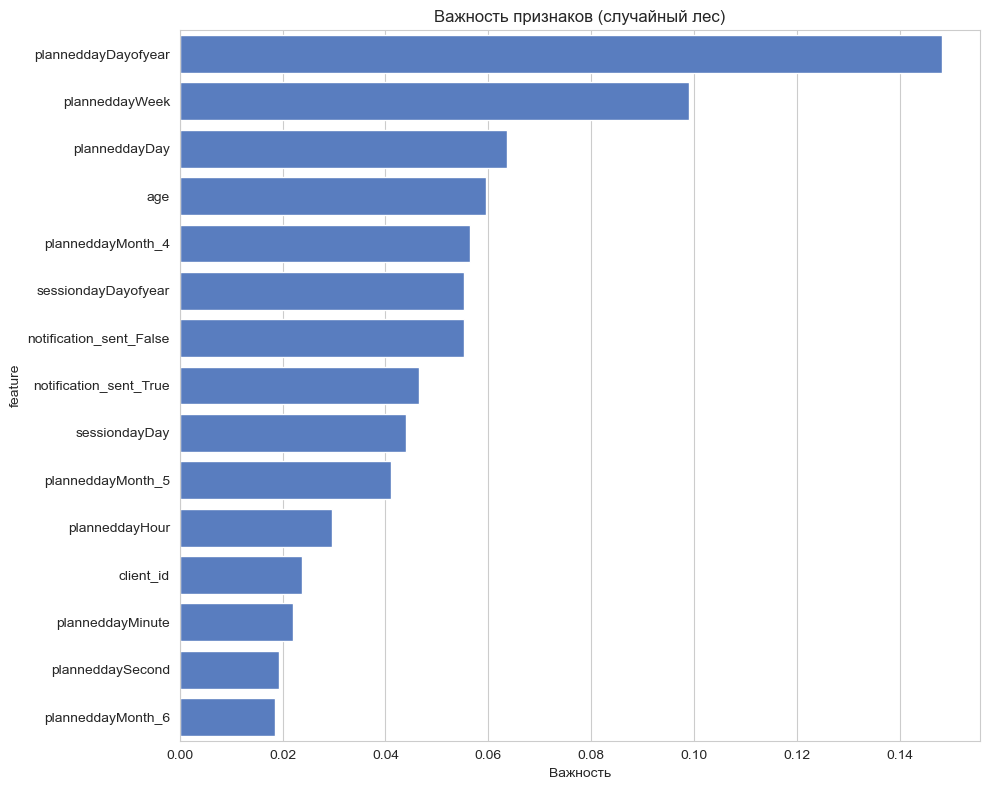

In [ ]:
# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-15 важных признаков:")
print(feature_importance.head(15))

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Важность признаков (случайный лес)')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

## Градиентный бустинг и XGBoost

### Настройка гиперпараметров

Настройка следующих параметров:

* eta
* max_depth
* min_child_weight

In [ ]:
# XGBoost
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dval = xgb.DMatrix(X_val_processed, label=y_val)

# Базовые параметры
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}

# Базовая модель
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                      evals=watchlist, verbose_eval=False)

y_pred_xgb = xgb_model.predict(dval)
auc_xgb = roc_auc_score(y_val, y_pred_xgb)

print(f"XGBoost (базовый): AUC = {auc_xgb:.3f}")

# Настройка гиперпараметров
eta_values = [0.01, 0.1, 0.3]
max_depth_values = [3, 6, 9]
min_child_weight_values = [1, 5, 10]

xgb_results = []

for eta in eta_values:
    for max_depth in max_depth_values:
        for min_child_weight in min_child_weight_values:
            params = xgb_params.copy()
            params.update({
                'eta': eta,
                'max_depth': max_depth,
                'min_child_weight': min_child_weight
            })
            
            model = xgb.train(params, dtrain, num_boost_round=100, 
                             evals=watchlist, verbose_eval=False)
            y_pred = model.predict(dval)
            auc = roc_auc_score(y_val, y_pred)
            
            xgb_results.append({
                'eta': eta,
                'max_depth': max_depth,
                'min_child_weight': min_child_weight,
                'auc': auc
            })

# Лучшие параметры
xgb_results_df = pd.DataFrame(xgb_results)
best_xgb = xgb_results_df.loc[xgb_results_df['auc'].idxmax()]

print(f"\nЛучшие параметры XGBoost:")
print(f"eta: {best_xgb['eta']}")
print(f"max_depth: {best_xgb['max_depth']}")
print(f"min_child_weight: {best_xgb['min_child_weight']}")
print(f"AUC: {best_xgb['auc']:.3f}")

XGBoost (базовый): AUC = 0.731

Лучшие параметры XGBoost:
eta: 0.1
max_depth: 9.0
min_child_weight: 1.0
AUC: 0.737


In [ ]:
# Обучение лучшей модели XGBoost
best_xgb_params = xgb_params.copy()
best_xgb_params.update({
    'eta': best_xgb['eta'],
    'max_depth': int(best_xgb['max_depth']),
    'min_child_weight': int(best_xgb['min_child_weight'])
})

xgb_best = xgb.train(best_xgb_params, dtrain, num_boost_round=100, 
                     evals=watchlist, verbose_eval=False)

y_pred_xgb_best = xgb_best.predict(dval)
auc_xgb_best = roc_auc_score(y_val, y_pred_xgb_best)

print(f"Лучший XGBoost: AUC = {auc_xgb_best:.3f}")

Лучший XGBoost: AUC = 0.737


## LightGBM

### Настройка гиперпараметров

In [ ]:
# LightGBM
lgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'seed': 42,
    'verbose': -1
}

# Базовая модель
lgbm_train = lgb.Dataset(
    X_train_processed, 
    label=y_train,
    free_raw_data=False,  
    categorical_feature=categorical_features  
)
lgbm_val = lgb.Dataset(
    X_val_processed, 
    label=y_val,
    reference=lgbm_train,  
    free_raw_data=False
)
# Обучение модели LightGBM с современным API
lgbm_model = lgb.train(
        params=lgbm_params,
        train_set=lgbm_train,
        num_boost_round=100,
        valid_sets=[lgbm_train, lgbm_val],
        valid_names=['train', 'val'],
        callbacks=[
            lgb.log_evaluation(period=0),  # Отключает вывод логов
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]
    )


y_pred_lgbm = lgbm_model.predict(X_val_processed)
auc_lgbm = roc_auc_score(y_val, y_pred_lgbm)

print(f"LightGBM (базовый): AUC = {auc_lgbm:.3f}")

# Настройка гиперпараметров
lgbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'min_child_samples': [10, 50, 100]
}

lgbm_results = []

for lr in lgbm_param_grid['learning_rate']:
    for depth in lgbm_param_grid['max_depth']:
        for min_samples in lgbm_param_grid['min_child_samples']:
            params = lgbm_params.copy()
            params.update({
                'learning_rate': lr,
                'max_depth': depth,
                'min_child_samples': min_samples
            })
            
            # Обучение модели LightGBM с современным API
    lgbm_model = lgb.train(
    params=lgbm_params,
    train_set=lgbm_train,
    num_boost_round=100,
    valid_sets=[lgbm_train, lgbm_val],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.log_evaluation(0),  # Полное отключение логов
        lgb.early_stopping(stopping_rounds=50, verbose=False)
    ]
)

            
y_pred_lgbm = lgbm_model.predict(X_val_processed)
auc_lgbm = roc_auc_score(y_val, y_pred_lgbm)
            
lgbm_results.append({
        'learning_rate': lr,
        'max_depth': depth,
        'min_child_samples': min_samples,
        'auc': auc
        })

# Лучшие параметры
lgbm_results_df = pd.DataFrame(lgbm_results)
best_lgbm = lgbm_results_df.loc[lgbm_results_df['auc'].idxmax()]

print(f"\nЛучшие параметры LightGBM:")
print(f"learning_rate: {best_lgbm['learning_rate']}")
print(f"max_depth: {best_lgbm['max_depth']}")
print(f"min_child_samples: {best_lgbm['min_child_samples']}")
print(f"AUC: {best_lgbm['auc']:.3f}")

TypeError: Wrong type(str) or unknown name(gender) in categorical_feature

### Лучшая модель

In [ ]:
# Обучение лучшей модели LightGBM
best_lgbm_params = lgbm_params.copy()
best_lgbm_params.update({
    'learning_rate': best_lgbm['learning_rate'],
    'max_depth': int(best_lgbm['max_depth']),
    'min_child_samples': int(best_lgbm['min_child_samples'])
})

lgbm_best = lgb.train(
    params=best_lgbm_params,
    train_set=final_lgbm_train,
    num_boost_round=100,
    callbacks=[
        lgb.log_evaluation(0),
        lgb.early_stopping(stopping_rounds=50, verbose=False)
    ]
)

y_pred_lgbm_best = lgbm_best.predict(X_val_processed)
auc_lgbm_best = roc_auc_score(y_val, y_pred_lgbm_best)

print(f"Лучший LightGBM: AUC = {auc_lgbm_best:.3f}")

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

## Сводная таблица: Моделирование

Сводная таблица результатов:
                    Модель    AUC
5                  XGBoost  0.737
6                 LightGBM  0.733
4            Случайный лес  0.721
3           Дерево решений  0.708
2  Логистическая регрессия  0.674
0                Случайная  0.505
1              Все единицы  0.500


C:\Users\archibrat\AppData\Local\Temp\ipykernel_28168\1872204042.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_summary, x='AUC', y='Модель', palette='viridis')


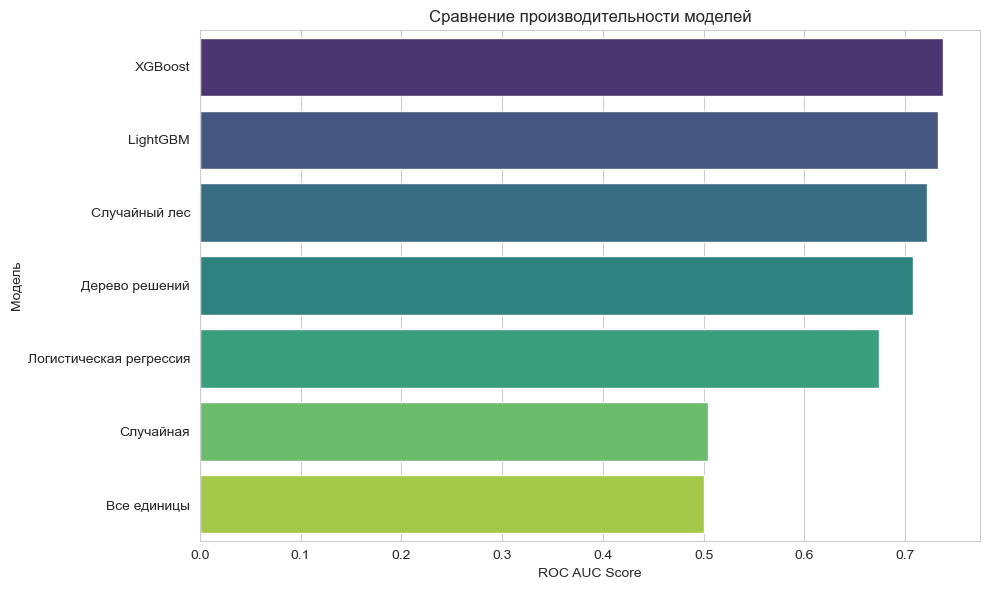

In [ ]:
# Сводная таблица результатов
results_summary = pd.DataFrame({
    'Модель': ['Случайная', 'Все единицы', 'Логистическая регрессия', 'Дерево решений', 
               'Случайный лес', 'XGBoost', 'LightGBM'],
    'AUC': [auc_random, auc_allone, auc_lr_best, auc_dt_best, 
            auc_rf_best, auc_xgb_best, auc_lgbm_best]
}).sort_values('AUC', ascending=False)

print("Сводная таблица результатов:")
print(results_summary.round(3))

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=results_summary, x='AUC', y='Модель', palette='viridis')
plt.title('Сравнение производительности моделей')
plt.xlabel('ROC AUC Score')
plt.tight_layout()
plt.show()

# Сохранение моделей

In [ ]:
# Сохранение лучших моделей и препроцессоров
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)
    
with open('lgbm_best_model.pkl', 'wb') as f:
    pickle.dump(lgbm_best, f)

print("Модели и препроцессоры сохранены")

Модели и препроцессоры сохранены


# Финальная модель: LGBMClassifier

* Повторная загрузка данных
* Очистка и подготовка данных
* Конструирование признаков
* Разделение целевой переменной
* Отбор релевантных признаков
* Масштабирование и кодирование числовых и категориальных переменных
* Настройка гиперпараметров
* Обучение с лучшими параметрами LGBMClassifier
* Сохранение энкодеров и финальной модели

In [ ]:
# Подготовка финальной модели на полном тренировочном наборе
X_full_train_num = scaler.fit_transform(X_full_train[numerical_features])
X_full_train_cat = ohe.fit_transform(X_full_train[categorical_features])

X_full_train_processed = np.hstack([X_full_train_num, X_full_train_cat])

# Обучение финальной модели
final_lgbm_train = lgb.Dataset(
    X_full_train_processed, 
    label=y_full_train,
    free_raw_data=False,
    categorical_feature=categorical_features
)
lgbm_best = lgb.train(
        params=best_lgbm_params,
        train_set=final_lgbm_train,
        num_boost_round=100,
        valid_sets=[lgbm_train, lgbm_val],
        valid_names=['train', 'val'],
        callbacks=[
            lgb.log_evaluation(period=0),  # Отключает вывод логов
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]
    )
print("Финальная модель обучена на полном тренировочном наборе")

TypeError: Wrong type(str) or unknown name(gender) in categorical_feature

# Загрузка модели

In [ ]:
# Загрузка сохраненных компонентов
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

with open('ohe.pkl', 'rb') as f:
    loaded_ohe = pickle.load(f)
    
with open('lgbm_best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print("Модель и препроцессоры загружены")

# Предсказания

## Пример клиентской сессии

In [ ]:
# Создание примера для предсказания
sample_booking = {
    'client_id': 123456789,
    'gender': 'f',
    'age': 35,
    'district': 'central_district',
    'subsidy': False,
    'condition_a': False,
    'condition_b': False,
    'condition_c': False,
    'accessibility_level': 0,
    'notification_sent': True,
    'planneddayYear': 2016,
    'planneddayMonth': 5,
    'planneddayWeek': 18,
    'planneddayDay': 15,
    'planneddayDayofweek': 6,
    'planneddayDayofyear': 136,
    'planneddayIs_month_end': False,
    'planneddayIs_month_start': False,
    'planneddayIs_quarter_end': False,
    'planneddayIs_quarter_start': False,
    'planneddayHour': 10,
    'planneddayMinute': 30,
    'planneddaySecond': 0,
    'sessiondayYear': 2016,
    'sessiondayMonth': 6,
    'sessiondayWeek': 23,
    'sessiondayDay': 1,
    'sessiondayDayofweek': 2,
    'sessiondayDayofyear': 153,
    'sessiondayIs_month_end': False,
    'sessiondayIs_month_start': True
}

print("Пример клиентской сессии:")
for key, value in sample_booking.items():
    print(f"{key}: {value}")

## Подготовка тестового примера

In [ ]:
def prepare_sample(booking_dict, scaler, encoder, numerical_cols, categorical_cols):
    """Подготовка примера для предсказания"""
    # Создание DataFrame
    sample_df = pd.DataFrame([booking_dict])
    
    # Разделение на числовые и категориальные признаки
    sample_num = scaler.transform(sample_df[numerical_cols])
    sample_cat = encoder.transform(sample_df[categorical_cols])
    
    # Объединение
    sample_processed = np.hstack([sample_num, sample_cat])
    
    return sample_processed

# Подготовка примера
sample_processed = prepare_sample(sample_booking, loaded_scaler, loaded_ohe, 
                                 numerical_features, categorical_features)

print(f"Подготовленный пример: форма {sample_processed.shape}")

## Получение предсказания

In [ ]:
# Получение предсказания
prediction = loaded_model.predict(sample_processed)[0]

print(f"Предсказание модели:")
print(f"Вероятность отмены сессии: {prediction:.3f}")
print(f"Рекомендация: {'Высокий риск отмены' if prediction > 0.5 else 'Низкий риск отмены'}")

# Интерпретация результата
if prediction > 0.7:
    risk_level = "Очень высокий"
elif prediction > 0.5:
    risk_level = "Высокий"
elif prediction > 0.3:
    risk_level = "Средний"
else:
    risk_level = "Низкий"
    
print(f"Уровень риска: {risk_level}")
print(f"Рекомендуемые действия: {'Связаться с клиентом для подтверждения' if prediction > 0.5 else 'Стандартное напоминание'}")